# The Last Jedi Reviews - Sentiment Analysis


In [1]:
import pandas as pd
import numpy as np

import re 
import string

import nltk
from nltk import word_tokenize
from nltk import sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# from google.cloud import language
# from google.cloud.language import enums
# from google.cloud.language import types

%matplotlib inline

# Append module location to path
import sys
sys.path.append("../code")
from confusion import print_confusion_matrix

import pickle

### Load Reviews

In [2]:
# Load pickle file with all IMDb reviews
tlj=pickle.load(open( "../data/pickles/reviews/imdb_tlj_reviews.pkl", "rb" ))

### Text Pre-Processing
- Remove numbers
- Lower case
- Remove punctuation
- Remove words with letter repetition
- Change scores from string to numeric

In [4]:
# Remove extraneous numbers, punctuation, words with excessive letter repetiion 
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
repeat_letters = lambda x: re.sub('(a{3,}|b{3,}|c{3,}|d{3,}|e{3,}|f{3,}|g{3,}|\
                                    h{3,}|i{2,}|j{2,}|k{3,}|l{3,}|m{3,}|n{3,}|\
                                    o{3,}|p{3,}|q{2,}|r{3,}|s{3,}|t{3,}|u{2,}|\
                                    v{2,}|w{3,}|x{2,}|y{2,}|z{3,})', ' ', x)


tlj['Reviews'] = tlj['Reviews'].map(alphanumeric).map(punc_lower).map(repeat_letters)

tlj['Scores'] = pd.to_numeric(tlj['Scores'])

### Create `Tokens` column in `tlj` DataFrame
Store the documents as bag-of-words representations in the df

In [5]:
# Create Tokens column
tlj['Tokens'] = tlj['Reviews'].apply(word_tokenize)

# Create list of documents in token form
all_tokens_list = list(tlj['Tokens'])

### Create `tljText` and `tljVocab` objects
Allow exploration of the vocabulary and usage of nltk.Text if needed

In [6]:
# Create list of all tokens, and NLTK Text and Vocab objects from tokens
all_tokens=[]
for i in all_tokens_list:
    all_tokens += i
tljText = nltk.Text(all_tokens)
tljVocab = sorted(set(tljText))

### Basic Sentiment Analysis with NLTK

In [7]:
compound_scores = []
valences = []
sid = SentimentIntensityAnalyzer()
for review in tlj['Reviews']:
    ss = sid.polarity_scores(review)
    for k in sorted(ss):
            if k == 'compound':
                compound_scores.append(ss[k])

In [8]:
# Add nltk scores to df
tlj['nltk_scores'] = pd.Series(compound_scores)

### Explore nltk_scores

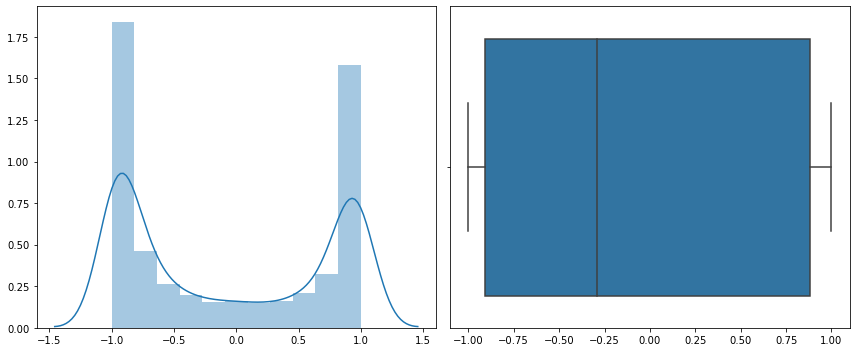

In [9]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(np.array(tlj['nltk_scores']), ax=axes[0])
sns.boxplot(np.array(tlj['nltk_scores']), ax=axes[1])
plt.tight_layout()

In [10]:
tlj.describe()

,Scores,nltk_scores
count,5664.000000,5865.000000
mean,4.224929,-0.069139
std,3.263339,0.817722
min,1.000000,-0.999800
25%,1.000000,-0.909800
50%,3.000000,-0.290500
75%,7.000000,0.879300
max,10.000000,0.999800


### Put scores on same scale
To make them easier to compare

In [11]:
# Multiply by 5 then add 5
tlj['nltk_scores'] = tlj['nltk_scores'] * 5 + 5

In [12]:
tlj.describe()

,Scores,nltk_scores
count,5664.000000,5865.000000
mean,4.224929,4.654306
std,3.263339,4.088610
min,1.000000,0.001000
25%,1.000000,0.451000
50%,3.000000,3.547500
75%,7.000000,9.396500
max,10.000000,9.999000


### Explore IMDb Scores

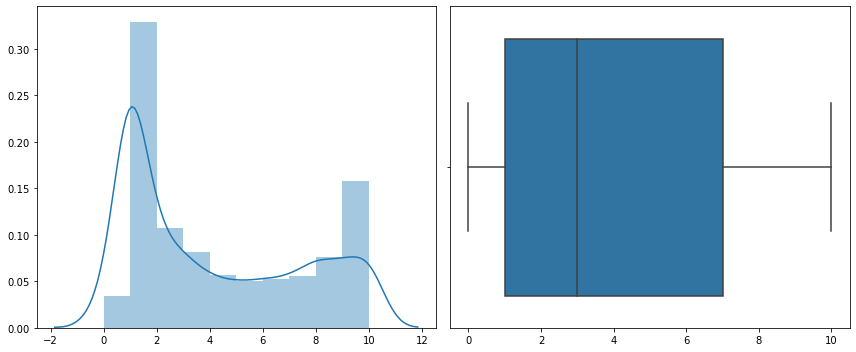

In [13]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(np.array(tlj['Scores'].fillna(0)), ax=axes[0], bins=10)
sns.boxplot(np.array(tlj['Scores'].fillna(0)), ax=axes[1])
plt.tight_layout()

- Well it would seem that the actual scores are far more negatively distributed than the sentiment scores. 
- To make it clearer what's going on between the two scoring methods, let's look at the plots side by side.

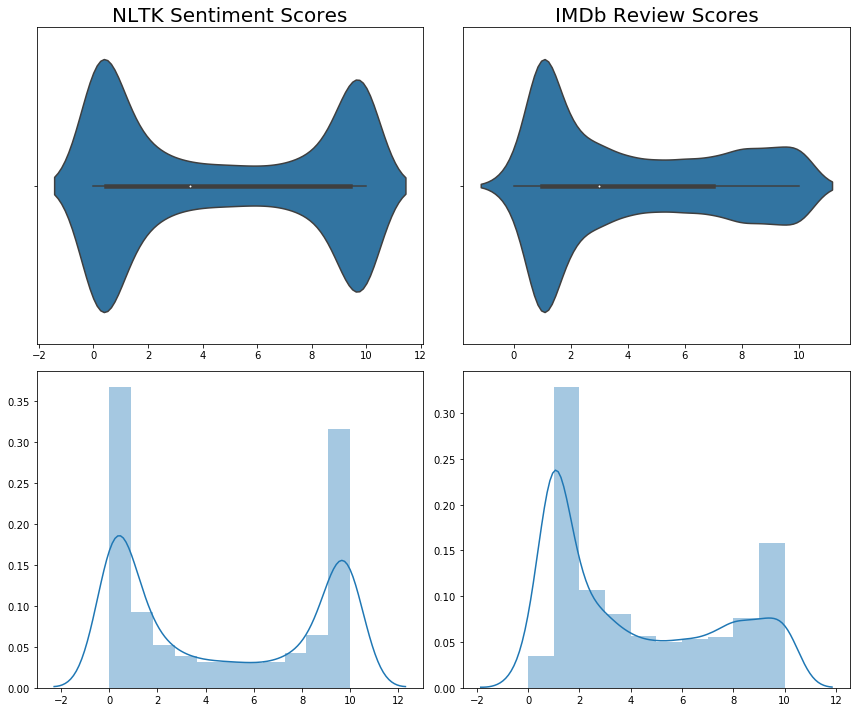

In [14]:

f, axes = plt.subplots(2,2, figsize=(12,10))
sns.violinplot(np.array(tlj['nltk_scores']), ax=axes[0,0]).set_title('NLTK Sentiment Scores',fontsize=20)
sns.violinplot(np.array(tlj['Scores'].fillna(0)), ax=axes[0,1]).set_title('IMDb Review Scores',fontsize=20)
sns.distplot(np.array(tlj['nltk_scores']), ax=axes[1,0])
sns.distplot(np.array(tlj['Scores'].fillna(0)), ax=axes[1,1], bins=10)
plt.tight_layout()

In [15]:
tlj.describe()

,Scores,nltk_scores
count,5664.000000,5865.000000
mean,4.224929,4.654306
std,3.263339,4.088610
min,1.000000,0.001000
25%,1.000000,0.451000
50%,3.000000,3.547500
75%,7.000000,9.396500
max,10.000000,9.999000


### Score to Sentiment Settings
Based on the above and general intuition about movie scoring, I'll set the sentiment values for numerical scores like this. A key thing to bear in mind here though is that even humans would have a hard time consistently translating the valence of a review into a score if they didn't write the review themselves. 
- __IMDb Scores__
    - 0 - 4 = "Negative"
    - 5 - 6 = "Neutral"
    - 7 - 10 = "Positive"
- __NLTK Scores__
    - 0.00 - 4.50 = "Negative"
    - 4.51 - 6.99 = "Neutral"
    - 7.00 - 10.0 = "Positive"

In [16]:
# Apply sentiments from nltk scores
nltk_sentiments = []
for i in tlj['nltk_scores']:
    if i >= 7:
        nltk_sentiments.append('positive')
    elif i > 4.5:
        nltk_sentiments.append('neutral')
    else:
        nltk_sentiments.append('negative')

IMDb_sentiments = []
for i in tlj['Scores']:
    if i >= 7:
        IMDb_sentiments.append('positive')
    elif i >= 5:
        IMDb_sentiments.append('neutral')
    else:
        IMDb_sentiments.append('negative')

In [17]:
tlj['nltk_sentiments'] = pd.Series(nltk_sentiments)
tlj['IMDb_sentiments'] = pd.Series(IMDb_sentiments)

### Sentiment Results for IMDb Score and NLTK Sentiment

In [18]:
print(tlj['nltk_sentiments'].value_counts())
print(tlj['IMDb_sentiments'].value_counts())

negative    3108
positive    2311
neutral      446
Name: nltk_sentiments, dtype: int64
negative    3567
positive    1696
neutral      602
Name: IMDb_sentiments, dtype: int64


### Calculate recall of nltk sentiment analysis
Recall in this case assumes that users scores are accurately reflecting the sentiment of their review. This should generally be the case, but highlights the difference between "sentiment" and "score". 

In [19]:
sent_true = np.array(tlj['IMDb_sentiments'])
sent_pred = np.array(tlj['nltk_sentiments'])
sent_conf = confusion_matrix(sent_true,sent_pred)

In [20]:
sent_conf

array([[2442,  295,  830],
       [ 271,   53,  278],
       [ 395,   98, 1203]])

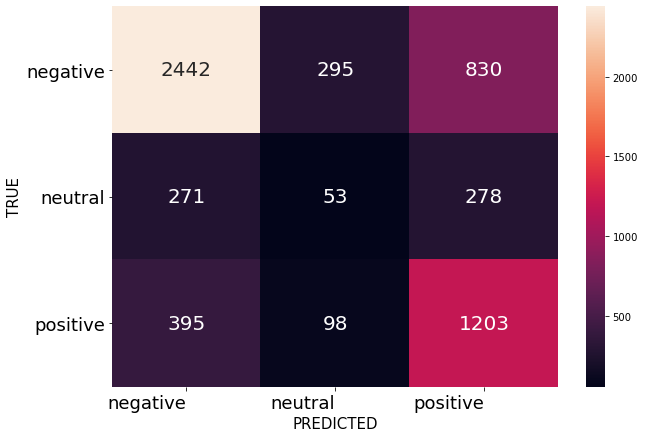

In [21]:
# Confusion Matrix of results for nltk predictions and IMDb truth
cm = print_confusion_matrix(sent_conf, ['negative', 'neutral', 'positive'])

### Manual Calculations
- Note I did these manual recall calculations below before I knew about the metrics functions in sklearn. Keeping them in for fun.

In [22]:
# Calculate individual recall
negative_recall = sent_conf[0,0]/np.sum(sent_conf[0])
neutral_recall = sent_conf[1,1]/np.sum(sent_conf[1])
positive_recall = sent_conf[2,2]/np.sum(sent_conf[2])

# Calculate weight of each category
total = np.sum(sent_conf)
neg_wt = np.sum(sent_conf[0])/total
neu_wt = np.sum(sent_conf[1])/total
pos_wt = np.sum(sent_conf[2])/total

# Calculate weighted overall accuracy
overall_recall = (negative_recall*neg_wt
                    + neutral_recall*neu_wt
                    + positive_recall*pos_wt)

In [23]:
print('Accuracy')
print('Negative recall:',negative_recall)
print('Neutral recall:',neutral_recall)
print('Positive recall:',positive_recall)
print()
print('Weights')
print('Negative weight:',neg_wt)
print('Neutral weight:',neu_wt)
print('Positive weight:',pos_wt)
print()
print('Overall accuracy:', overall_recall)

Accuracy
Negative recall: 0.6846089150546678
Neutral recall: 0.08803986710963455
Positive recall: 0.7093160377358491

Weights
Negative weight: 0.6081841432225064
Neutral weight: 0.10264279624893435
Positive weight: 0.28917306052855923

Overall accuracy: 0.6305200341005968


- Not amazing accuracy. Some of this is undoubtedly due to the difference between a score and perceived sentiment, which may not align even be consistent with the user writing them.
- However, if the sentiment analysis is accurate it should be much higher than this. We'll see if other methods work better. 

## Sentiment Analysis with Google Cloud
Try the Google Cloud sentiment analyzer and compare to NLTK

In [32]:
# # Instantiates a client
# path = open('/Users/starplatinum87/Google Drive/google_cloud_account_credential/google_cloud_credential_path.txt','r').read().strip()

# # Authenticate client
# client = language.LanguageServiceClient.from_service_account_json(path)

#### Notes on Google API scoring
- __magnitude__ - A non-negative number in the (0, +inf) range, which represents the absolute magnitude of sentiment regardless of score (positive or negative).
- __score__ - Sentiment score between -1.0 (negative sentiment) and 1.0 (positive sentiment).
- https://cloud.google.com/natural-language/docs/reference/rest/v1/Sentiment

In [33]:
# %%time
# # Test sentiment analysis on first review
# text = tlj['Reviews'].iloc[0]
# document = types.Document(
#     content=text, 
#     type=enums.Document.Type.PLAIN_TEXT)
# sentiment = client.analyze_sentiment(document=document).document_sentiment

CPU times: user 26.2 ms, sys: 7.92 ms, total: 34.2 ms
Wall time: 821 ms


In [34]:
# print('Score:', sentiment.score)
# print('Magnitude:', sentiment.magnitude)

Score: -0.699999988079071
Magnitude: 1.399999976158142


In [35]:
# # Run Google Sentiment Analysis on all reviews
# gscore = []
# gmag = []
# for i in tlj['Reviews']:
#     document = types.Document(
#         content=i,
#         type=enums.Document.Type.PLAIN_TEXT)
#     sentiment = client.analyze_sentiment(document=document).document_sentiment
#     gscore.append(sentiment.score)
#     gmag.append(sentiment.magnitude)

## Import Pickled Google Sentiment Scores
- Import scores generated from the code above

In [24]:
# Import pickled Google sentiment scores
gscore = pickle.load(open('../data/pickles/sentiment_analysis/google_sentiment_scores.pickle', 'rb'))
gmag = pickle.load(open('../data/pickles/sentiment_analysis/google_magnitude_scores.pickle', 'rb'))

In [25]:
# Add Google scores to tlj df
tlj['google_score'] = pd.Series(gscore)
tlj['google_magnitude'] = pd.Series(gmag)

In [38]:
# with open('tlj_v2', 'wb') as write_file:
#     pickle.dump(tlj, write_file)

In [39]:
# with open('google_sentiment_scores.pickle', 'wb') as write_file:
#     pickle.dump(gscore, write_file)
    
# with open('google_magnitude_scores.pickle', 'wb') as write_file:
#     pickle.dump(gmag, write_file)

In [26]:
# Put google scores on same scale as ratings
gscore_scaled = []
for i in gscore:
    normalized = (i+1)*5
    gscore_scaled.append(normalized)
gscore_scaled

[1.5000000596046448,
 3.999999985098839,
 1.5000000596046448,
 0.5000001192092896,
 0.5000001192092896,
 2.5,
 0.5000001192092896,
 1.5000000596046448,
 1.5000000596046448,
 0.5000001192092896,
 0.9999999403953552,
 7.5,
 0.5000001192092896,
 0.5000001192092896,
 0.9999999403953552,
 0.5000001192092896,
 0.9999999403953552,
 7.5,
 0.5000001192092896,
 0.5000001192092896,
 0.5000001192092896,
 1.5000000596046448,
 0.9999999403953552,
 1.5000000596046448,
 0.5000001192092896,
 2.9999999701976776,
 0.9999999403953552,
 0.5000001192092896,
 1.5000000596046448,
 0.5000001192092896,
 1.5000000596046448,
 0.9999999403953552,
 0.5000001192092896,
 0.5000001192092896,
 0.9999999403953552,
 0.9999999403953552,
 0.5000001192092896,
 0.5000001192092896,
 1.5000000596046448,
 0.9999999403953552,
 0.5000001192092896,
 1.5000000596046448,
 1.5000000596046448,
 0.9999999403953552,
 1.5000000596046448,
 0.9999999403953552,
 1.5000000596046448,
 0.9999999403953552,
 1.5000000596046448,
 8.49999994039535

In [27]:
# Add scaled sentiment scores to df
tlj['google_score'] = pd.Series(gscore_scaled)

In [28]:
# Sentiment words for Google score intervals
google_sentiment_words = []
for i in tlj['google_score']:
    if i >= 6.9:
        google_sentiment_words.append('positive')
    elif i > 4.49:
        google_sentiment_words.append('neutral')
    else:
        google_sentiment_words.append('negative')

In [29]:
# Append Google sentiment words column
tlj['google_sentiment'] = pd.Series(google_sentiment_words)

### Visual EDA of Google scores

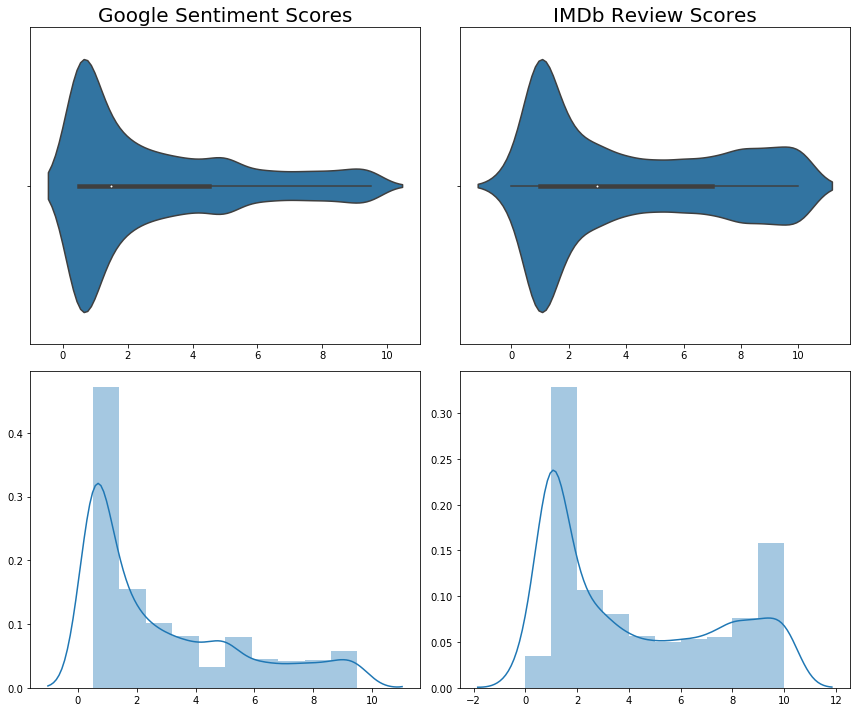

In [30]:
f, axes = plt.subplots(2,2, figsize=(12,10))
sns.violinplot(np.array(tlj['google_score']), ax=axes[0,0]).set_title('Google Sentiment Scores', fontsize=20)
sns.violinplot(np.array(tlj['Scores'].fillna(0)), ax=axes[0,1]).set_title('IMDb Review Scores', fontsize=20)
sns.distplot(np.array(tlj['google_score']), ax=axes[1,0], bins=10)
sns.distplot(np.array(tlj['Scores'].fillna(0)), ax=axes[1,1], bins=10)
plt.tight_layout()

- We can see with the EDA that the Google estimates of sentiment are __much closer__ to the IMDb sentiment actuals.

### Calculate accuracy of Google sentiment analysis

In [31]:
sent_true = np.array(tlj['IMDb_sentiments'])
sent_pred = np.array(tlj['google_sentiment'])
sent_conf = confusion_matrix(sent_true,sent_pred)

In [32]:
sent_conf

array([[3239,  233,   95],
       [ 505,   70,   27],
       [ 531,  533,  632]])

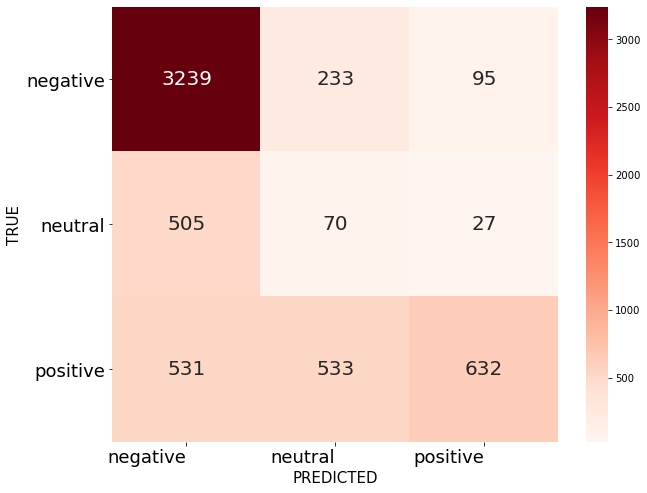

In [33]:
# Confusion Matrix of results for nltk predictions and IMDb truth
cm = print_confusion_matrix(sent_conf, ['negative', 'neutral', 'positive'], cmap='Reds', figsize=(10,8))

### Calculate Google sentiment accuracy

In [34]:
# Calculate individual recall
negative_recall = sent_conf[0,0]/np.sum(sent_conf[0])
neutral_recall = sent_conf[1,1]/np.sum(sent_conf[1])
positive_recall = sent_conf[2,2]/np.sum(sent_conf[2])

# Calculate weight of each category
total = np.sum(sent_conf)
neg_wt = np.sum(sent_conf[0])/total
neu_wt = np.sum(sent_conf[1])/total
pos_wt = np.sum(sent_conf[2])/total

# Calculate weighted overall accuracy
overall_recall = (negative_recall*neg_wt
                    + neutral_recall*neu_wt
                    + positive_recall*pos_wt)

In [55]:
print('Accuracy')
print('Negative recall:',negative_recall)
print('Neutral recall:',neutral_recall)
print('Positive recall:',positive_recall)
print()
print('Weights')
print('Negative weight:',neg_wt)
print('Neutral weight:',neu_wt)
print('Positive weight:',pos_wt)
print()
print('Overall recall:', overall_recall)

Accuracy
Negative recall: 0.9080459770114943
Neutral recall: 0.11627906976744186
Positive recall: 0.37264150943396224

Weights
Negative weight: 0.6081841432225064
Neutral weight: 0.10264279624893435
Positive weight: 0.28917306052855923

Overall recall: 0.6719522591645354


- Now this is quite interesting. The __positive and neutral recall is significantly worse than nltk__, but __the negative accuracy is MUCH higher, at 0.908__. 
- Since the negative recall is what I'm most interested in, this works out very well. 
- Also of note is that the overall recall is higher, though not by much. 
- So __I will use the Google sentiment results for the topic modeling portion__. 

In [56]:
# with open('tlj_v2.pickle', 'wb') as write_file:
#     pickle.dump(tlj, write_file)

## Sentiment Analysis Conclusions
- The overall best performer was the Google Cloud sentiment analysis tool. This isn't surprising since it is after all, Google and I would expect a paid service from one of the foremost ML and AI companies in the world to do well on this task. 
- Additionally it performed exceedingly well on properly identifying negative sentiment, but somewhat poorly on the other two categories. I could speculate as to why this is. My best theory is that negative sentiment in these reviews is well-pronounced. It is rarely vague or couched. This was a polarizing movie and those who took to the internet to express themselves about it did not like it. This is reflected in the contrast between the average score from those who left reviews. Roughly 5800 left written reviews and their average scores was 4.22. However 446k left a score and the average of those who just left a score is 7.2. While IMDb may be doing some weighting behind the scenes to combat obvious attempts to stuff the ballot, __the difference in average score between those who did and those who didn't leave a written review strongly implies a negative bias for those who wrote a review__. This is the internet and this is a polarizing movie so none of this is surprising, but it is interesting to see it play out in raw numbers. 
- __I'll proceed with the Google sentiment analysis results to categorize review sentiment when topic modeling__.